# Quick Intro to pyRoot

Here's a *very* brief introduction to pyRoot (python interface for root). root as a tool for data analysis and plotting is sort of being phased out in high energy physics, but knowing the basics is definitely useful.

First, you'll need to import the ROOT library. I've also included uproot here, which is only used for input and output of root files (mostly in machine learning contexts, but it can make accessing objects from root files easier in some cases). When you use uproot you also often need to use the awkard array library, which you also need to import

For more info on uproot: https://uproot.readthedocs.io/en/latest/index.html
For more info on ROOT: https://root.cern/doc/master/  - note that most of the documentation is for the C++ interface, not pyROOT, which can be confusing. 


In [1]:
import ROOT
import uproot
import awkward as ak

Welcome to JupyROOT 6.28/06


Next step is opening a root file. Here's how to do it using ROOT:

In [2]:
filename="WHleptonicpythia_generic_M125.0_MD2.00_T0.50_HT-1_UL18_NANOAOD.root"
ROOT_file=ROOT.TFile.Open(filename)

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


And in uproot:

In [3]:
uproot_file=uproot.open(filename)

Ok, now we want to see what's in the file. 
In ROOT we use file.ls(), uproot uses file.keys()

In [4]:
ROOT_file.ls()

TNetXNGFile**		root://eoshome-i04.cern.ch//eos/user/c/cmauceri/SWAN_projects/SUEPS/WHleptonicpythia_generic_M125.0_MD2.00_T0.50_HT-1_UL18_NANOAOD.root	
 TNetXNGFile*		root://eoshome-i04.cern.ch//eos/user/c/cmauceri/SWAN_projects/SUEPS/WHleptonicpythia_generic_M125.0_MD2.00_T0.50_HT-1_UL18_NANOAOD.root	
  KEY: TObjString	untagged;1	Collectable string class
  KEY: TTree	Events;1	Events
  KEY: TTree	LuminosityBlocks;1	LuminosityBlocks
  KEY: TTree	Runs;1	Runs
  KEY: TTree	MetaData;1	Job metadata
  KEY: TTree	ParameterSets;1	Parameter sets


In [5]:
uproot_file.keys()

['untagged;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

Root files usually contain objects called trees, which contain branches. Usually the tree you're interested in will be called "Events" or something like that. (In HEP, an event refers to the results of a proton-proton collision, so if your file has 40,000 events, it contains results from 40,000 collisions!)

Branches contain information from one aspect of each event. Depending on the branch, there can be multiple entries per event (vector) or only one (scalar). For example, a branch called "Nmuon" would only have one entry per event (the number of muons produced), while "muon_pt" will have an entry for the transverse momentum of each muon produced. 

Let's see what's in our file:

In [6]:
# ROOT
ROOT_tree=ROOT_file.Get("Events")
ROOT_tree.Print()

******************************************************************************
*Tree    :Events    : Events                                                 *
*Entries :    40000 : Total =      6846006773 bytes  File  Size =  946198314 *
*        :          : Tree compression factor =   7.24                       *
******************************************************************************
*Br    0 :run       : run/i                                                  *
*Entries :    40000 : Total  Size=     163977 bytes  File Size  =       6920 *
*Baskets :       40 : Basket Size=      32000 bytes  Compression=  23.54     *
*............................................................................*
*Br    1 :luminosityBlock : luminosityBlock/i                                *
*Entries :    40000 : Total  Size=     164505 bytes  File Size  =       7400 *
*Baskets :       40 : Basket Size=      32000 bytes  Compression=  22.08     *
*...................................................

In [27]:
# uproot
uproot_tree=uproot_file['Events']
uproot_tree.keys()

['run',
 'luminosityBlock',
 'event',
 'HTXS_Higgs_pt',
 'HTXS_Higgs_y',
 'HTXS_stage1_1_cat_pTjet25GeV',
 'HTXS_stage1_1_cat_pTjet30GeV',
 'HTXS_stage1_1_fine_cat_pTjet25GeV',
 'HTXS_stage1_1_fine_cat_pTjet30GeV',
 'HTXS_stage1_2_cat_pTjet25GeV',
 'HTXS_stage1_2_cat_pTjet30GeV',
 'HTXS_stage1_2_fine_cat_pTjet25GeV',
 'HTXS_stage1_2_fine_cat_pTjet30GeV',
 'HTXS_stage_0',
 'HTXS_stage_1_pTjet25',
 'HTXS_stage_1_pTjet30',
 'HTXS_njets25',
 'HTXS_njets30',
 'nboostedTau',
 'boostedTau_chargedIso',
 'boostedTau_eta',
 'boostedTau_leadTkDeltaEta',
 'boostedTau_leadTkDeltaPhi',
 'boostedTau_leadTkPtOverTauPt',
 'boostedTau_mass',
 'boostedTau_neutralIso',
 'boostedTau_phi',
 'boostedTau_photonsOutsideSignalCone',
 'boostedTau_pt',
 'boostedTau_puCorr',
 'boostedTau_rawAntiEle2018',
 'boostedTau_rawIso',
 'boostedTau_rawIsodR03',
 'boostedTau_rawMVAnewDM2017v2',
 'boostedTau_rawMVAoldDM2017v2',
 'boostedTau_rawMVAoldDMdR032017v2',
 'boostedTau_charge',
 'boostedTau_decayMode',
 'boostedTau_je

There's a *lot* of stuff in this file, most of which we won't need!
For this tutorial I'll focus on some of the electron branches, but feel free to play around with it and look at the other ones!

When you're dealing with huge datasets like this, it's not realistic to look at the results of every single event. We're more interested in looking at overall distributions (histograms!), or specific events that fit some criteria. Root has it's own class for making histograms which gets used a lot in HEP. 

First, we construct the histogram:

In [32]:
#hist=ROOT.TH1D("hist_name","hist title",numberofbins,bin_min,bin_max)
# For electron pT:
e_pT_hist=ROOT.TH1D("e_pT", "electron pT", 100, 0, 200)

Warning in <TNetXNGFile::Append>: Replacing existing TH1: e_pT (Potential memory leak).


Try making your own for electron phi!
(hint for the bin min and max: phi is an angle...)

In [65]:
e_phi_hist = ROOT.TH1D("e_phi", "electron phi", 100, -4, 4)

Warning in <TNetXNGFile::Append>: Replacing existing TH1: e_phi (Potential memory leak).


Now we want to fill the histogram with the relevant data. 

First using ROOT:


In [34]:
for event in ROOT_tree:
    for electron in ROOT_tree.Electron_pt:
        e_pT_hist.Fill(electron)

Now using uproot (we have to construct a new histogram so we don't fill it twice, but the results will be the same)

In [66]:
uproot_e_pT_hist=ROOT.TH1D("uproot_e_pT", "electron pT", 100, 0, 200)
uproot_e_vars=uproot_tree.arrays(['Electron_pt','Electron_phi']) # this converts the data in the tree to arrays
uproot_e_pT=uproot_e_vars.Electron_pt
for event in uproot_e_pT:
    for electron in event:
        uproot_e_pT_hist.Fill(electron)

Warning in <TNetXNGFile::Append>: Replacing existing TH1: uproot_e_pT (Potential memory leak).


Uproot tends to be faster for reading/writing from a file, filling histograms, etc. But it's good to know the syntax for both just in case!

To draw histograms in root, we use the canvas class:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


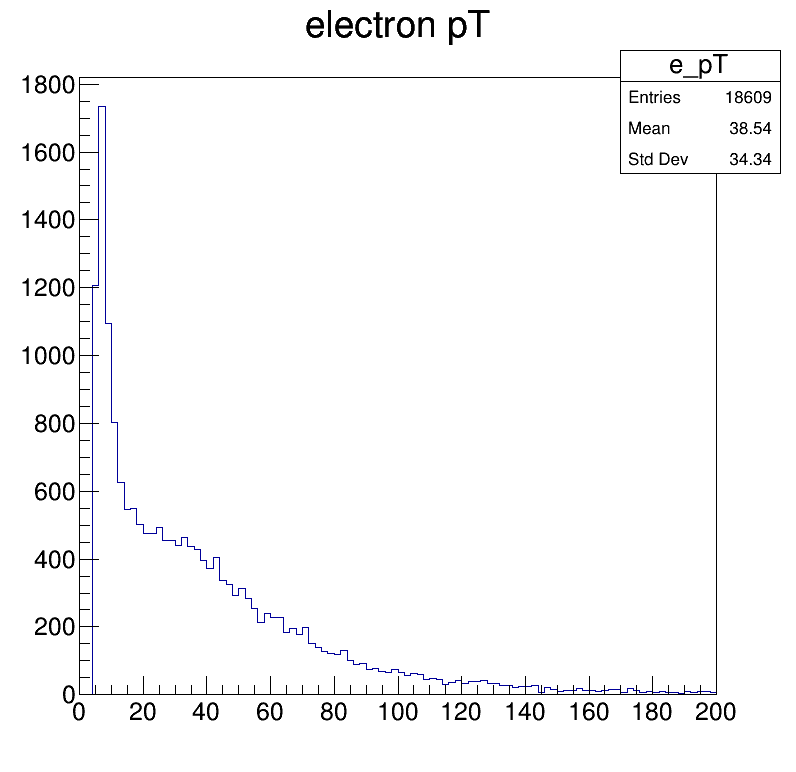

In [36]:
canvas=ROOT.TCanvas("canvas","",800,800)
canvas.Draw()
e_pT_hist.Draw()

Just for sanity, let's check that the histogram we filled using uproot syntax looks the same

Info in <TCanvas::Print>: png file e_pT.png has been created


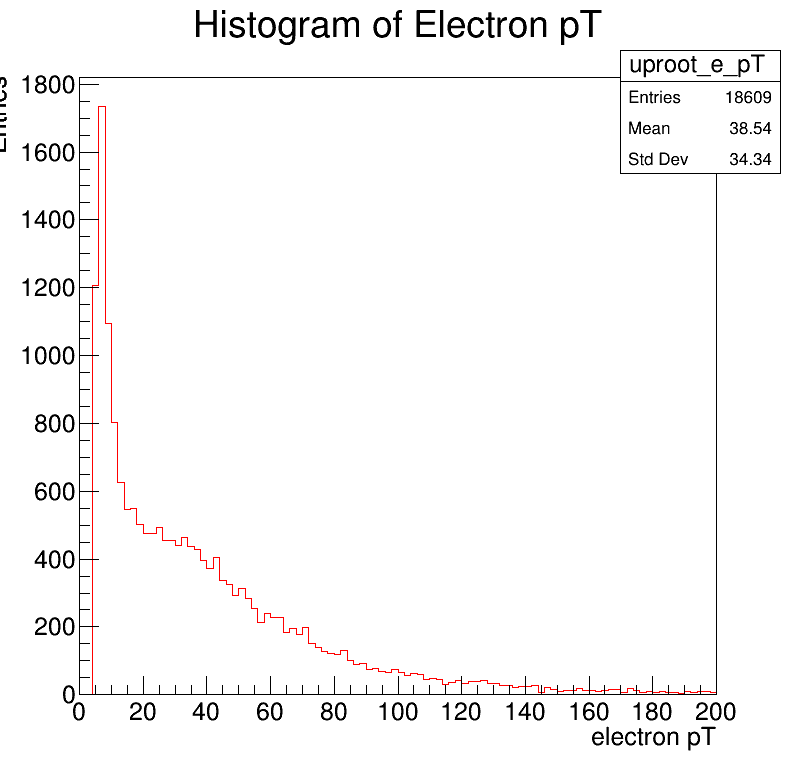

In [69]:
canvas.Draw()
uproot_e_pT_hist.SetLineColor(2) # this just changes the color so we can see we're plotting the right thing
uproot_e_pT_hist.GetXaxis().SetTitle("electron pT")
uproot_e_pT_hist.GetYaxis().SetTitle("Entries")
uproot_e_pT_hist.SetTitle("Histogram of Electron pT")
uproot_e_pT_hist.Draw()
canvas.SaveAs("e_pT.png") # this saves it as an image in the folder you're working in

Try filling the electron phi histogram you made earlier:

In [67]:
e_phi=uproot_e_vars.Electron_phi
for event in e_phi:
    for electron in event:
        # Fill histogram

And drawing it:

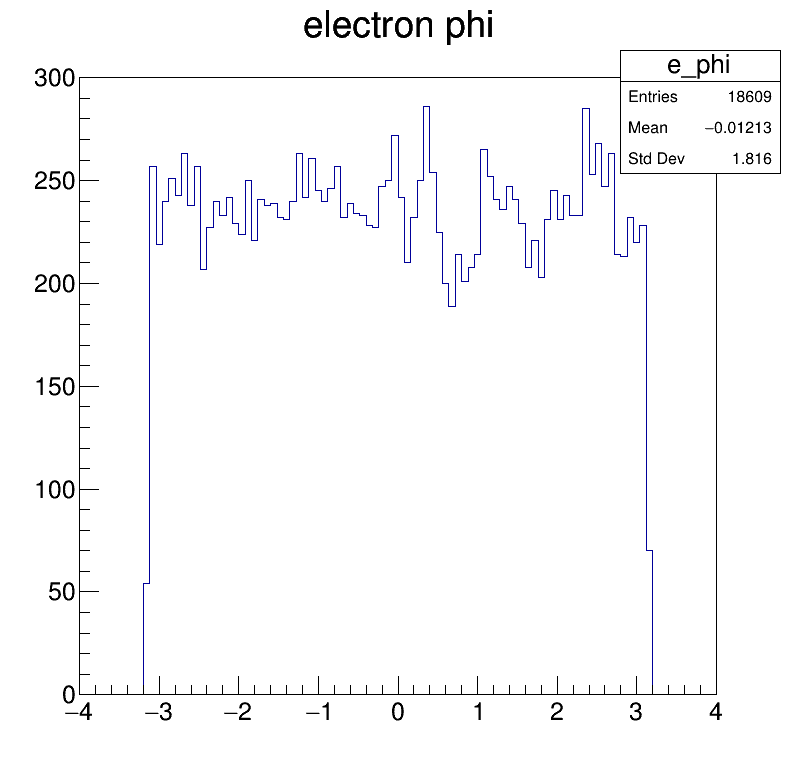

In [68]:
## Fill in here

We can also plot two histograms at the same time. Let's look at some distributions for both muons and electrons.

First, we need to make our histograms for the muons

In [71]:
muon_vars=uproot_tree.arrays(['Muon_pt','Muon_phi'])
mu_pT=muon_vars.Muon_pt
mu_phi=muon_vars.Muon_phi
mu_pT_hist=# Fill in here
mu_phi_hist=# Fill in here
for (pT_ev,phi_ev) in zip(mu_pT,mu_phi):
    for (pT_mu,phi_mu) in zip(pT_ev, phi_ev):
        mu_pT_hist.Fill(pT_mu)
        mu_phi_hist.Fill(phi_mu)


Now we can plot $\phi$ for both muons and electrons. ROOT.TLegend adds a legend to your plot.

Info in <TCanvas::Print>: png file phi_mu_electrons.png has been created


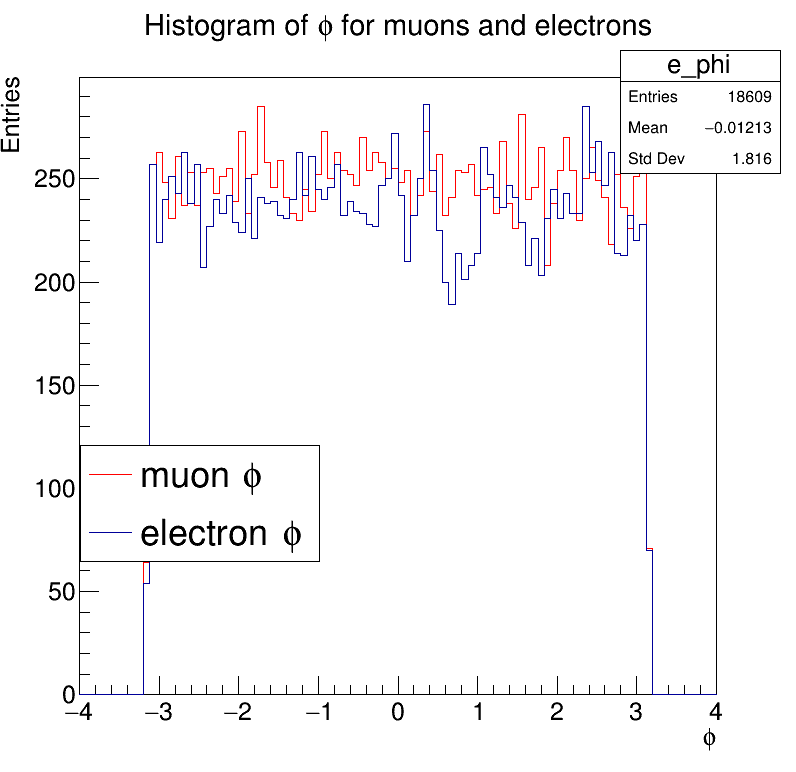

In [81]:
canvas.Draw()
mu_phi_hist.SetLineColor(2)
mu_phi_hist.GetXaxis().SetTitle("#phi")
mu_phi_hist.GetYaxis().SetTitle("Entries")
mu_phi_hist.SetTitle("Histogram of #phi for muons and electrons")
mu_phi_hist.Draw()
e_phi_hist.Draw("SAME")
legend=ROOT.TLegend()
legend.AddEntry(mu_phi_hist, "muon #phi","L")
legend.AddEntry(e_phi_hist, "electron #phi","L")
legend.Draw()
canvas.SaveAs("phi_mu_electrons.png")

Fill in to repeat for pT:

Info in <TCanvas::Print>: png file pT_mu_electrons.png has been created


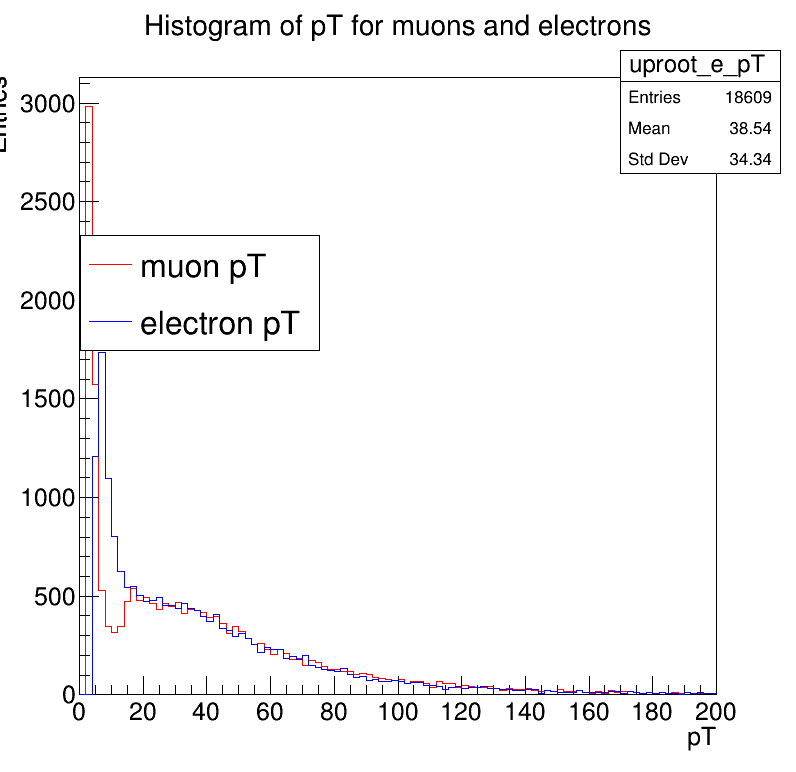

In [89]:
canvas.Draw()
mu_pT_hist.SetLineColor(2)
uproot_e_pT_hist.SetLineColor(4) # This is just to keep the colors consistent 
# Fill in here
canvas.SaveAs("pT_mu_electrons.png")

That's all for this tutorial! Hopefully this was a helpful introduction to opening root files and viewing their contents, and basic plotting using pyRoot.